In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, recall_score

from imblearn.combine import SMOTEENN

import xgboost as xgb

import optuna

Let's read the data and look at the shape and the structure of the data

In [2]:
df = pd.read_csv("./data/data.csv")

In [3]:
df.shape

(6819, 96)

In [4]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


We have 96 columns and the target variable is "Bankrupt?" column. So we have too many features. We will check a feature importance and select a subset of features for the model. 

In [5]:
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

We see that there are unnecessary the spacing in the naming of the columns, so we remove them. 

In [6]:
df.columns = df.columns.str.strip()

Checking missing values and duplication:

In [7]:
print('Rows with missing values:', (df.isna().sum()>0).sum())
print('Number of duplicated rows:', df.duplicated().sum())

Rows with missing values: 0
Number of duplicated rows: 0


Let's have a look to simple statistics for each column. 

In [8]:
pd.set_option('display.max_columns', None)
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

"Net Income Flag" feature is equal to 1 for all rows, so we delete this column.

In [9]:
df.drop(columns=['Net Income Flag'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [11]:
df['Liability-Assets Flag'].unique()

array([0, 1], dtype=int64)

Observations:
- By reading the name of the features, we suspect that the data has many of correleted columns;
- The onlycategorical variable is "Liability-Assets Flag".

Next we check the distribution of the target variable.

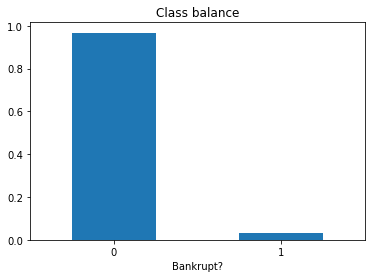

In [12]:
df['Bankrupt?'].value_counts(normalize=True).plot(kind='bar', rot=0.25)
plt.xlabel("Bankrupt?")
plt.title("Class balance")
plt.show()

We have imbalance class and we need to take that into accout while building a model.

Since we have too many features, it worth to perform feature selection by estimating mutual information and by computing the ANOVA F-value.

In [13]:
independent_variable = df.drop(['Bankrupt?'], axis=1)
target_variable = df[['Bankrupt?']]

importances_mutual = mutual_info_classif(independent_variable,pd.Series.ravel(target_variable))
importances_mutual = pd.Series(importances_mutual,independent_variable.columns[0:len(independent_variable.columns)])
importances_mutual = pd.DataFrame({'features':importances_mutual.index, 'importance':importances_mutual.values})

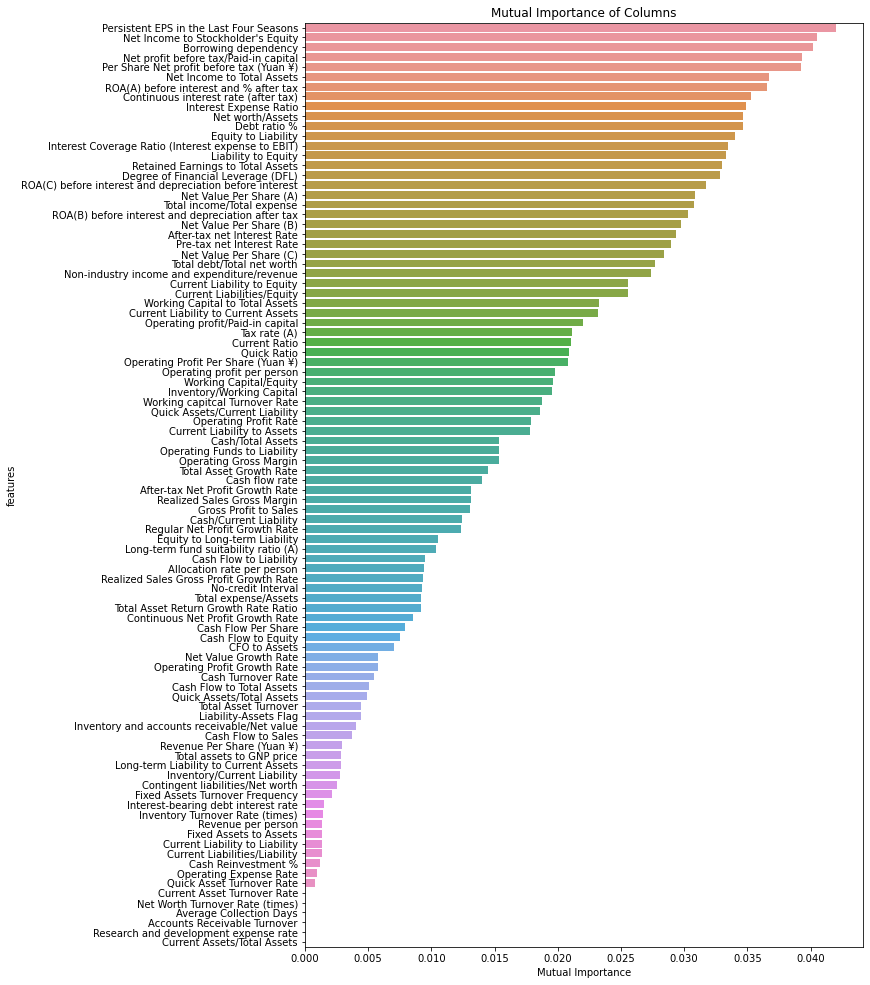

In [14]:
plt.figure(figsize=(10, 17))
sns.barplot(data = importances_mutual, y = "features", x = "importance",order=importances_mutual.sort_values('importance', ascending=False).features)
plt.xlabel("Mutual Importance")
plt.title("Mutual Importance of Columns")
plt.show()

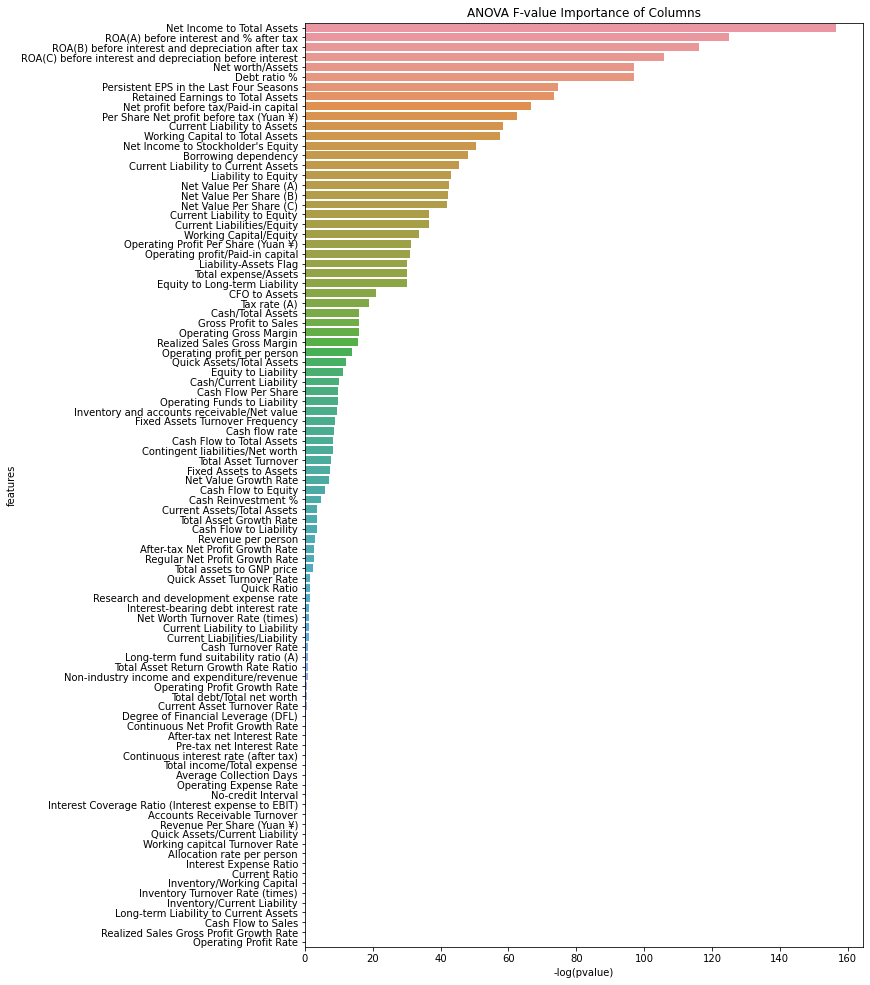

In [15]:
importances_f = f_classif(independent_variable,pd.Series.ravel(target_variable))
importances_f = pd.Series(-np.log10(importances_f[1]),independent_variable.columns[0:len(independent_variable.columns)])
importances_f = pd.DataFrame({'features':importances_f.index, 'importance':importances_f.values})

plt.figure(figsize=(10, 17))
sns.barplot(data = importances_f, y = "features", x = "importance", order=importances_f.sort_values('importance', ascending=False).features)
plt.xlabel("-log(pvalue)")
plt.title("ANOVA F-value Importance of Columns")
plt.show()

We select top 15 columns for each method for further study.

In [16]:
n = 15
selected_set_mutual = np.array(importances_mutual.nlargest(n,'importance').features)
selected_set_f = np.array(importances_f.nlargest(n,'importance').features)

In [17]:
selected_columns = [*selected_set_mutual , *selected_set_f]
selected_columns = np.unique(selected_columns)
print('Number of selected columns:', len(selected_columns))
print(*selected_columns, sep = "\n")

Number of selected columns: 20
Borrowing dependency
Continuous interest rate (after tax)
Current Liability to Assets
Current Liability to Current Assets
Debt ratio %
Equity to Liability
Interest Coverage Ratio (Interest expense to EBIT)
Interest Expense Ratio
Liability to Equity
Net Income to Stockholder's Equity
Net Income to Total Assets
Net profit before tax/Paid-in capital
Net worth/Assets
Per Share Net profit before tax (Yuan ¥)
Persistent EPS in the Last Four Seasons
ROA(A) before interest and % after tax
ROA(B) before interest and depreciation after tax
ROA(C) before interest and depreciation before interest
Retained Earnings to Total Assets
Working Capital to Total Assets


Let's have a look a correlation of selected features.

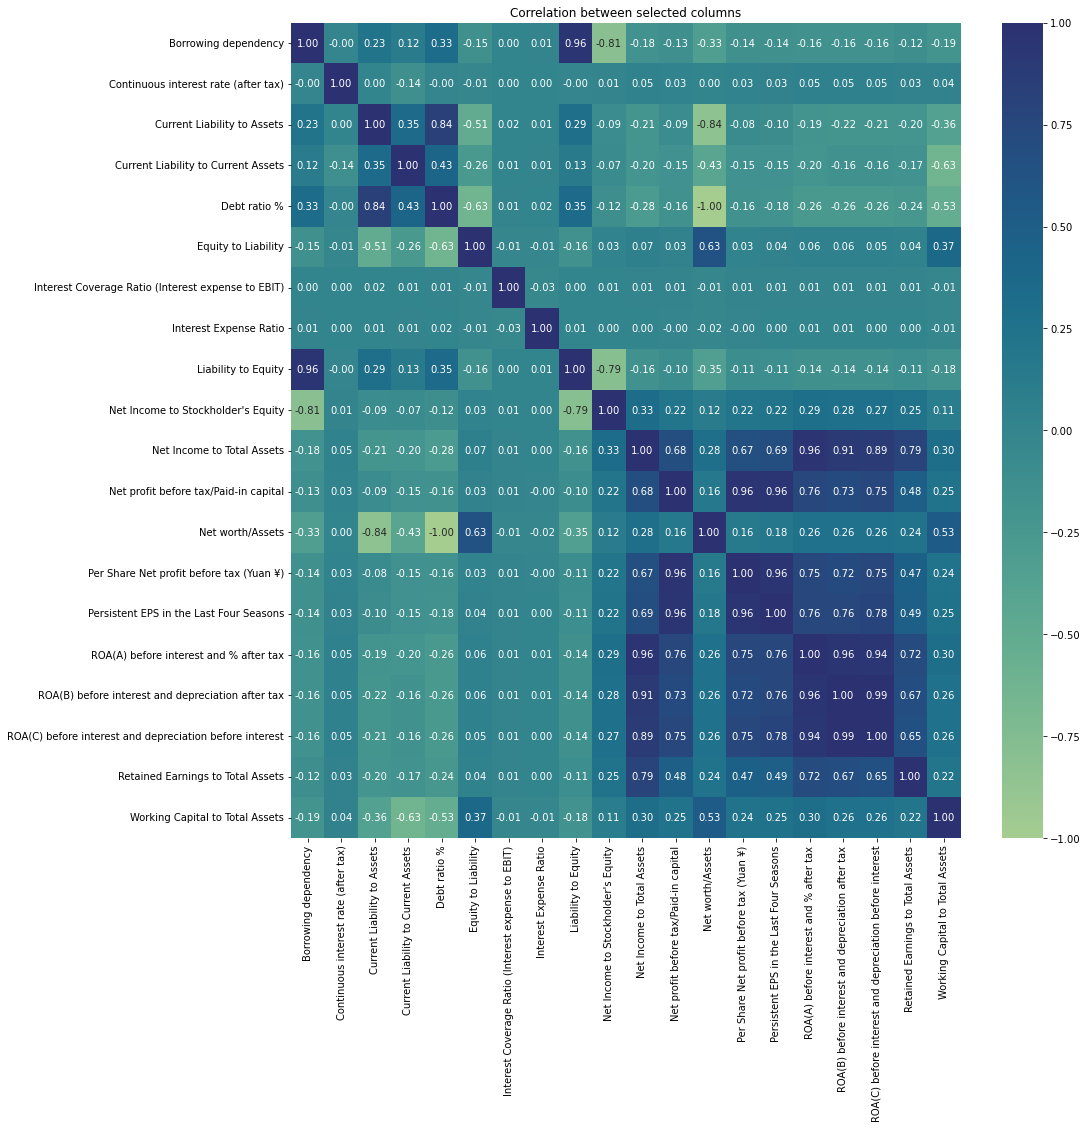

In [18]:
plt.figure(figsize=(15, 15))
sns.heatmap(df[selected_columns].corr(),cmap="crest",annot=True, fmt=".2f")
plt.title("Correlation between selected columns")
plt.show()

We select features which are not highly correlated.

In [19]:
selected_columns = ['Continuous interest rate (after tax)',
                    'Debt ratio %',
                    'Degree of Financial Leverage (DFL)',
                    'Current Liability to Current Assets', 
                    'Equity to Liability',
                    'Interest Coverage Ratio (Interest expense to EBIT)',
                    'Interest Expense Ratio', 
                    "Net Income to Stockholder's Equity",
                    'Net Income to Total Assets',
                    'Persistent EPS in the Last Four Seasons']
print(len(selected_columns))

10


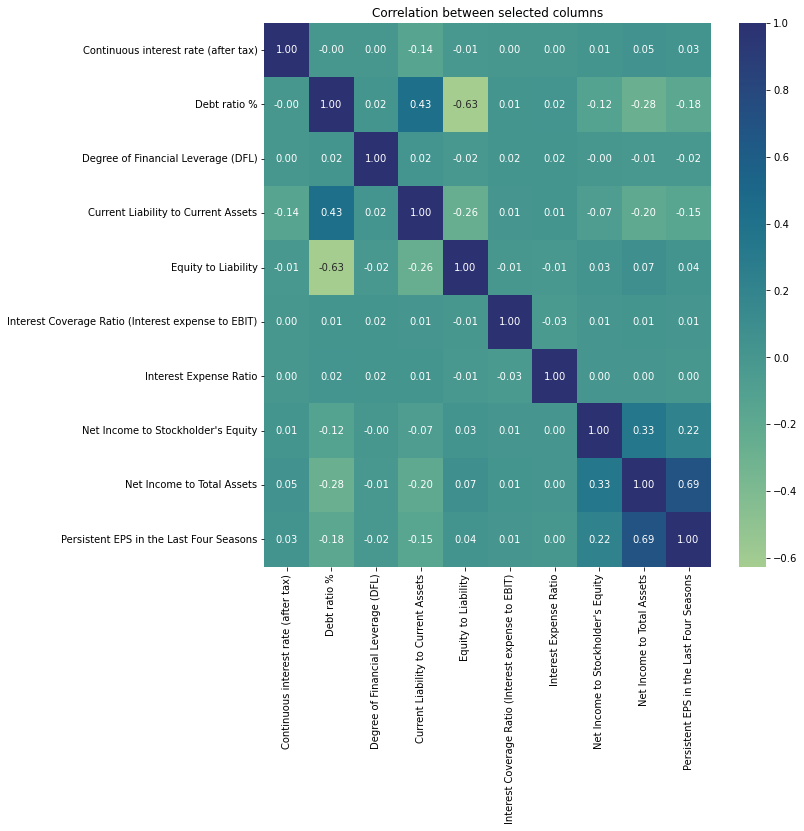

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(df[selected_columns].corr(), cmap="crest", annot=True, fmt=".2f")
plt.title("Correlation between selected columns")
plt.show()

In [21]:
cols = ['Bankrupt?'] + selected_columns
selected_df = df[cols]
selected_df.head()

,Bankrupt?,Continuous interest rate (after tax),Debt ratio %,Degree of Financial Leverage (DFL),Current Liability to Current Assets,Equity to Liability,Interest Coverage Ratio (Interest expense to EBIT),Interest Expense Ratio,Net Income to Stockholder's Equity,Net Income to Total Assets,Persistent EPS in the Last Four Seasons
0,1,0.780985,0.207576,0.026601,0.118250,0.016469,0.564050,0.629951,0.827890,0.716845,0.169141
1,1,0.781506,0.171176,0.264577,0.047775,0.020794,0.570175,0.635172,0.839969,0.795297,0.208944
2,1,0.780284,0.207516,0.026555,0.025346,0.016474,0.563706,0.629631,0.836774,0.774670,0.180581
3,1,0.781241,0.151465,0.026697,0.067250,0.023982,0.564663,0.630228,0.834697,0.739555,0.193722
4,1,0.781550,0.106509,0.024752,0.047725,0.035490,0.575617,0.636055,0.839973,0.795016,0.212537


We present the pairwise scatterplot and boxplot for each feature.

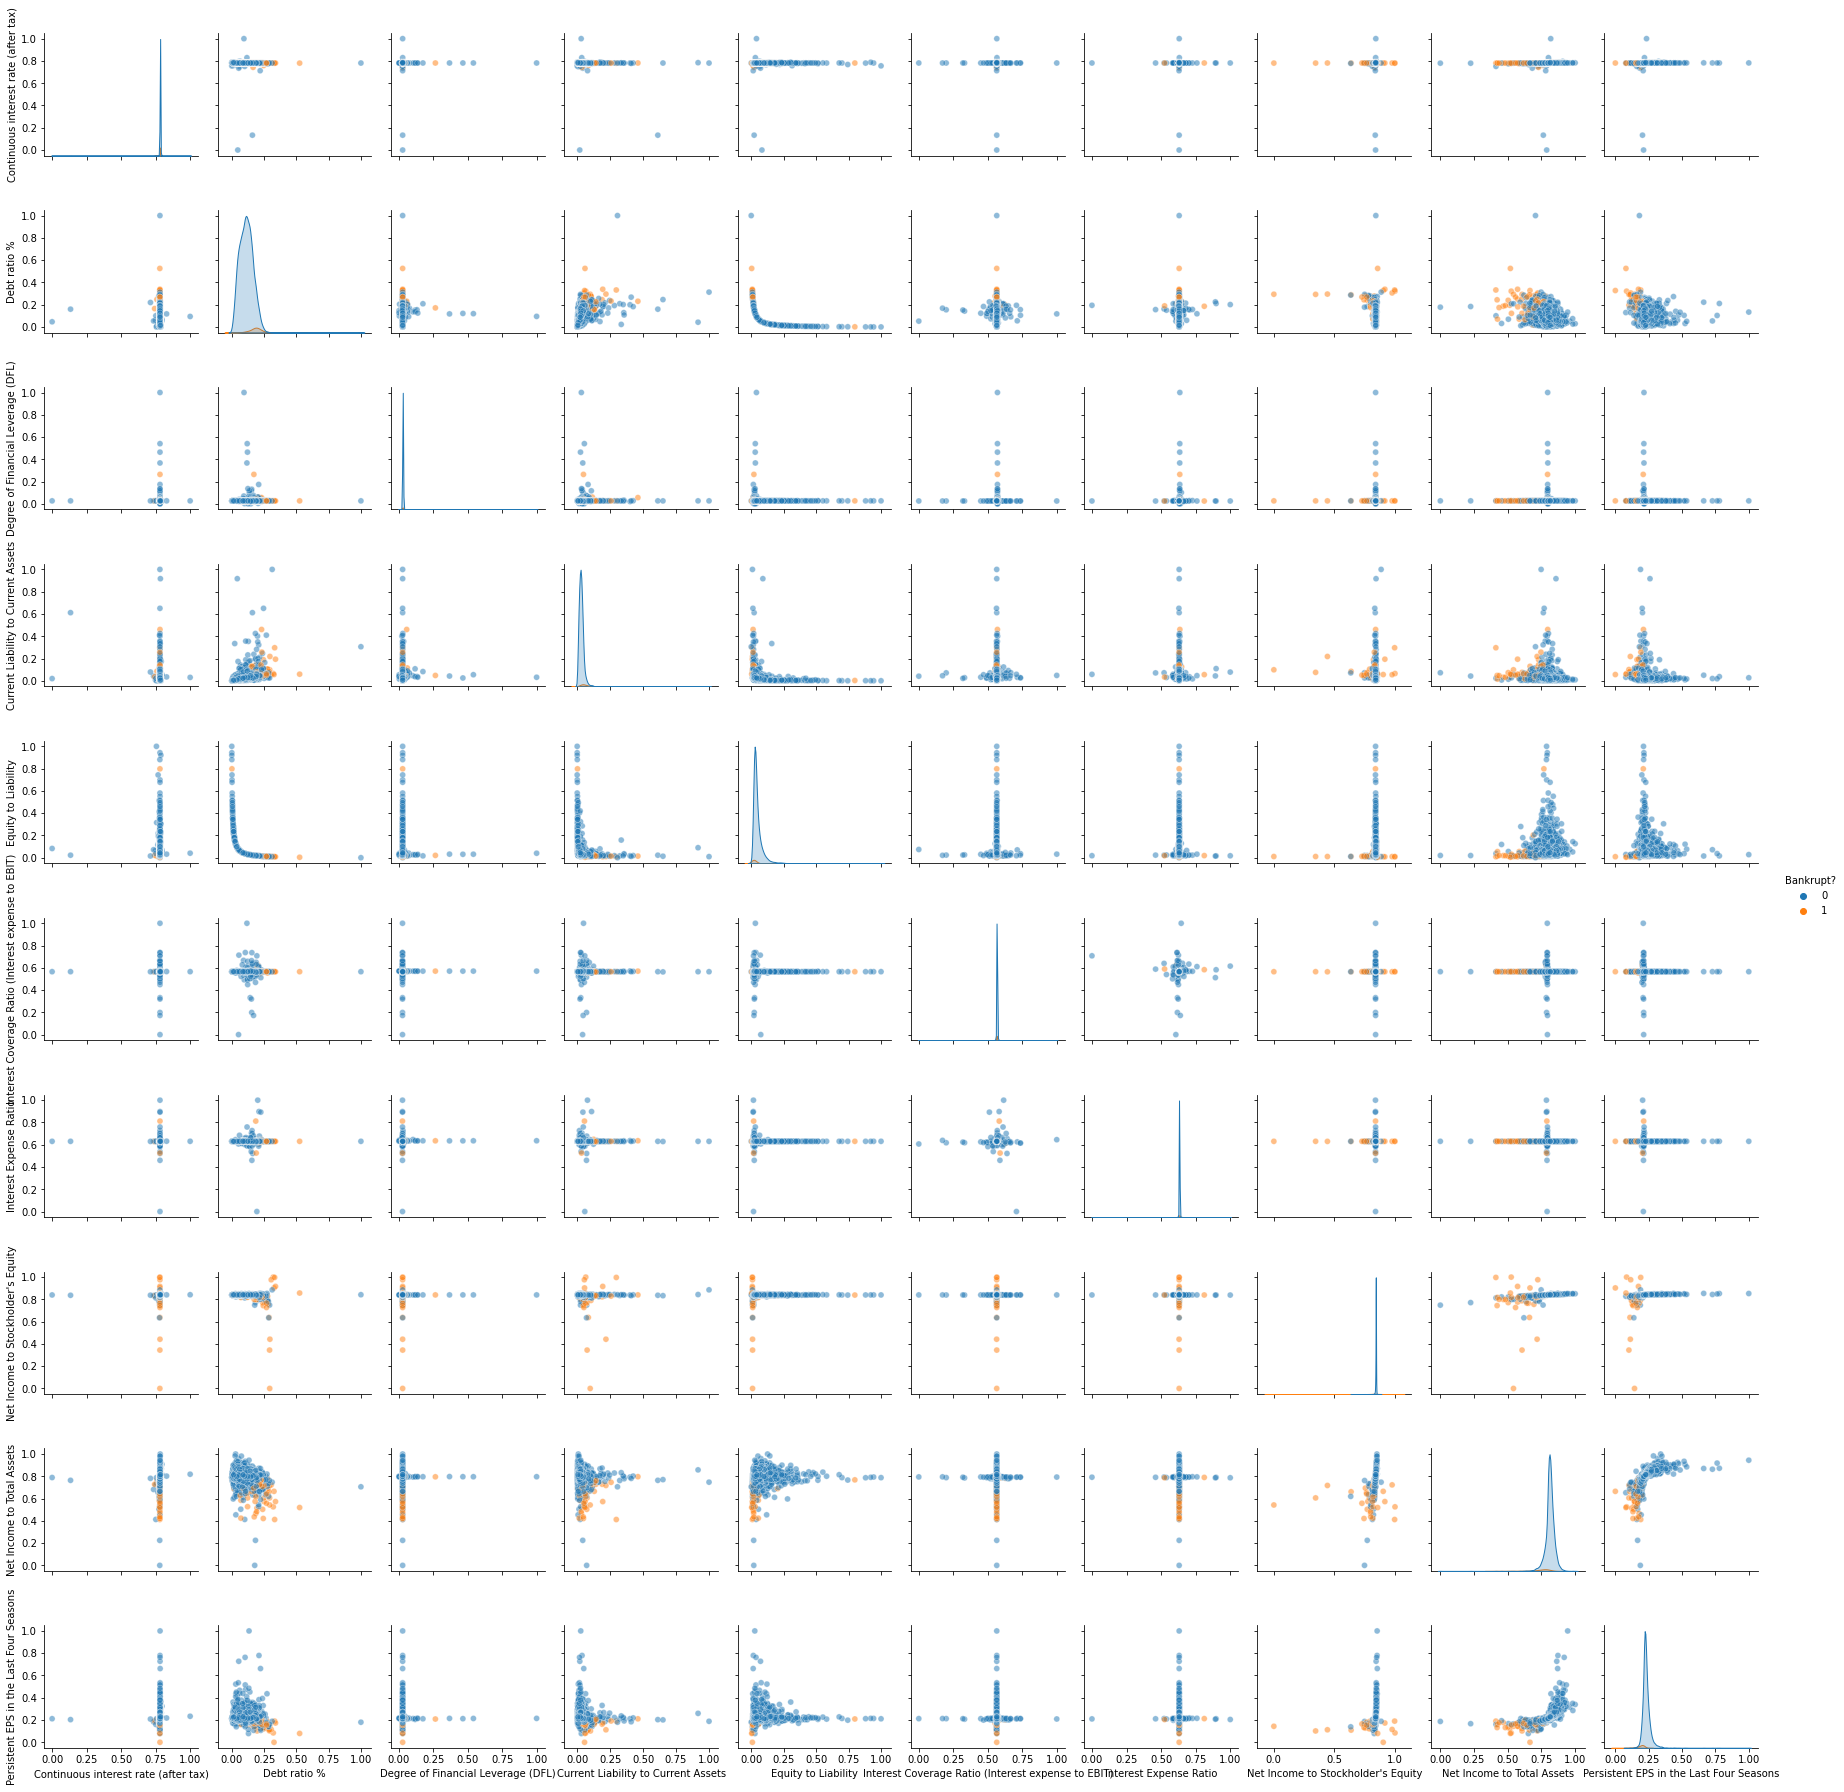

In [22]:
sns.pairplot(selected_df, hue='Bankrupt?', plot_kws={'alpha': 0.5})
plt.show()

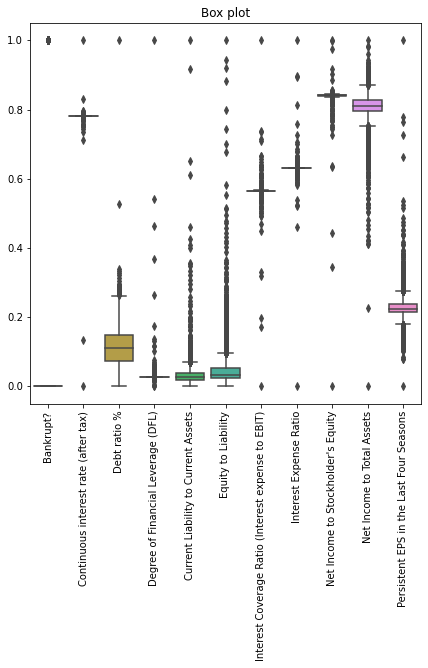

In [23]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=selected_df)
plt.xticks(rotation=90)
plt.title("Box plot")
plt.show()

Let's split data into train, val and test. We use stratify option to make sure that we keep the ratio of bankrupt companies in the sets.

In [24]:
# prepare data
df_full_train, df_test = train_test_split(selected_df, test_size=0.2, random_state=1, stratify=selected_df['Bankrupt?'])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train['Bankrupt?'])

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train['Bankrupt?'].values
y_train = df_train['Bankrupt?'].values
y_val = df_val['Bankrupt?'].values
y_test = df_test['Bankrupt?'].values

del df_train['Bankrupt?']
del df_val['Bankrupt?']
del df_test['Bankrupt?']
del df_full_train['Bankrupt?']

Since our data is heavily imbalance, we apply SMOTE+ENN method to resample the train dataset. This way we improve the balance of the target variable. See [SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html) for more details. Then we apply XGBoost Classifier for the resampled data.

In [25]:
sm = SMOTEENN(random_state=42)
df_train_res, y_train_res = sm.fit_resample(df_train, y_train)

model = xgb.XGBClassifier()
model.fit(df_train_res, y_train_res)
y_pred = model.predict(df_val)
print(classification_report(y_val, y_pred))
print('Roc auc score on val set:', round(roc_auc_score(y_val, model.predict_proba(df_val)[:, 1]), 3))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1320
           1       0.22      0.70      0.34        44

    accuracy                           0.91      1364
   macro avg       0.61      0.81      0.64      1364
weighted avg       0.96      0.91      0.93      1364

Roc auc score on val set: 0.889


We perform hyperparameter optimisation using Optuna. See [Optuna](https://optuna.readthedocs.io/en/stable/index.html) for more details. We choose Recall as the objective function to maximise.

In [26]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.001, 1.0, log=True),
        'n_jobs': trial.suggest_int('n_jobs', -1, -1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        #'scale_pos_weight': trial.suggest_int('scale_pos_weight', 30, 500),
        #'max_delta_step': trial.suggest_int('max_delta_step', 1, 10)
    }

    sm = SMOTEENN(random_state=42)
    df_train_res, y_train_res = sm.fit_resample(df_train, y_train)
    model = xgb.XGBClassifier(**params)
    model.fit(df_train_res, y_train_res)
    
    #y_pred_proba = model.predict_proba(df_val)
    #y_pred = model.predict(df_val)
    #f_1 = f1_score(y_val, y_pred, average='macro')
    #roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])

    y_pred = model.predict(df_val)
    recall = recall_score(y_val, y_pred)
    
    return recall

# Run the hyperparameter optimization with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:", study.best_trial.params)
print("Best score:", study.best_value)

[I 2023-11-05 22:49:21,621] A new study created in memory with name: no-name-56228883-aa8c-47d2-8396-f658361b3524
[I 2023-11-05 22:49:22,036] Trial 0 finished with value: 0.75 and parameters: {'eta': 0.09356510259255589, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.05470198287479567, 'n_jobs': -1, 'n_estimators': 61}. Best is trial 0 with value: 0.75.
[I 2023-11-05 22:49:22,383] Trial 1 finished with value: 0.7727272727272727 and parameters: {'eta': 0.09193913533183141, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.023812964380029476, 'n_jobs': -1, 'n_estimators': 150}. Best is trial 1 with value: 0.7727272727272727.
[I 2023-11-05 22:49:22,834] Trial 2 finished with value: 0.7272727272727273 and parameters: {'eta': 0.0662312316480955, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.010496030303269887, 'n_jobs': -1, 'n_estimators': 183}. Best is tri

Best trial: {'eta': 0.04591064618345001, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.08394452858954751, 'n_jobs': -1, 'n_estimators': 100}
Best score: 0.7954545454545454


In [27]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

Finally, we train the best model on the full train set and evaluate metrics on the test set.

In [28]:
sm = SMOTEENN(random_state=42)
df_full_train_res, y_full_train_res = sm.fit_resample(df_full_train, y_full_train)
model = xgb.XGBClassifier(**study.best_trial.params)
model.fit(df_full_train_res, y_full_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04591064618345001,
              eval_metric=None, feature_types=None, gamma=0.08394452858954751,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

In [29]:
y_pred = model.predict(df_test)
print(classification_report(y_test, y_pred))
print('Roc auc score on test set:', round(roc_auc_score(y_test, model.predict_proba(df_test)[:, 1]), 3))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1320
           1       0.18      0.80      0.29        44

    accuracy                           0.87      1364
   macro avg       0.58      0.84      0.61      1364
weighted avg       0.97      0.87      0.91      1364

Roc auc score on test set: 0.93
